In [7]:
import sys, os
import dask
from dask.diagnostics import ProgressBar

sys.path.append(os.path.dirname(os.getcwd()) ) # add hextof-processor to path
from processor.DldFlashDataframeCreatorExpress import DldFlashProcessorExpress, DldProcessor
# from processor.DldFlashDataframeCreator import DldFlashProcessor # Only necessary for comparing with old data
from processor.utilities import calibration, diagnostics, misc, io, vis,dfops
settings = 'Jonas_2020_express'


# first time readout: slow

In [8]:
# prc = readData(35995,settings=settings)
prc = DldFlashProcessorExpress(35993,settings=settings)

Using settings from Jonas_2020_express.ini


In [9]:
from timeit import default_timer as timer
start = timer()
prc.readData()
end = timer()
print(f'elapsed time: {end - start}')

reading runs_ run35993: 6 new files of 6 total.
Loading 6 dataframes. Failed reading 0 files.
elapsed time: 33.45084448903799


# Second time readout: one new file just arrived! very fast :)

In [5]:
start = timer()
prc.readData()
end = timer()
print(f'elapsed time: {end - start}')

reading runs_ run35995: 0 new files of 29 total.
Loading 29 dataframes. Failed reading 0 files.
elapsed time: 7.61269421223551


# Binning and compare to old readout

In [4]:
# prc = readData(35990,settings=settings)
prc.addBinning('dldTime',580,800,0.01)
res = prc.computeBinnedData()

  0%|          | 0/3 [00:00<?, ?it/s]

Generating metadata...
Failed creating metadata: 'timeStamp'


In [68]:
prc.dd

,trainId,pulseId,electronId,bam,delayStage,cryoTemperature,dldTimeBinSize,extractorCurrent,extractorVoltage,sampleBias,sampleTemperature,tofVoltage,dldPosX,dldPosY,dldTime,gmdBda,gmdTunnel,monochromatorPhotonEnergy,opticalDiode
npartitions=27,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [62]:
prcold = DldFlashProcessor(settings=settings)
prcold.runNumber = 35990
prcold.readDataframes()
prcold.addBinning('dldTime',580,800,0.01)
resold = prc.computeBinnedData()

Using settings from Jonas_2020_express.ini
Searching for parquet data from run35990...
no run info available.
Loading complete.


  0%|          | 0/3 [00:00<?, ?it/s]

Failed creating metadata: 'forced to skip metadata creation'


<IPython.core.display.Javascript object>


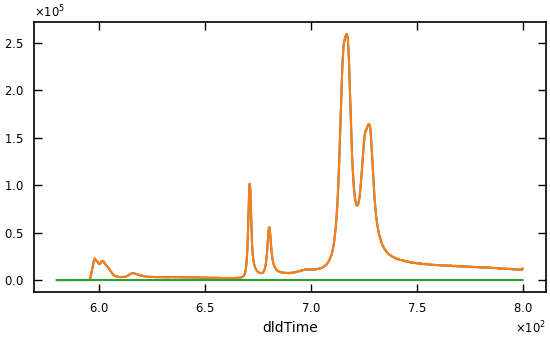

In [64]:
plt.figure()
res.plot()
resold.plot()
(res-resold).plot()

In [11]:
prc = readData(35990,settings=settings)
prc.resetBins()
prc.addBinning('dldTime',580,800,0.01)
prc.addBinning('dldPosX',400,900,4)
prc.addBinning('dldPosY',400,900,4)
prc.addBinning('delayStage',*dask.compute(prc.dd.delayStage.min(),prc.dd.delayStage.max()),0.5)
res4D = prc.computeBinnedData()


Using settings from Jonas_2020_express.ini
reading runs run35990: 0 new files of 27 total.
Loading 27 dataframes. Failed reading 0 files.


  0%|          | 0/3 [00:00<?, ?it/s]

Failed creating metadata: 'forced to skip metadata creation'


<IPython.core.display.Javascript object>


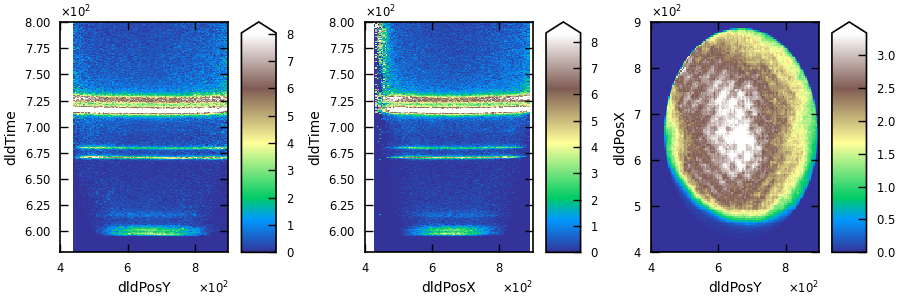

In [16]:
f,ax = plt.subplots(1,3,figsize=(9,3))
r = res4D.mean('delayStage')
img = r.sel(dldPosX=slice(640,660)).mean('dldPosX')
img = img/img.mean('dldTime')
img.plot(cmap='terrain',robust=True,ax=ax[0])
img = r.sel(dldPosY=slice(640,660)).mean('dldPosY')
img = img/img.mean('dldTime')
img.plot(cmap='terrain',robust=True,ax=ax[1])
img = r.sel(dldTime=slice(710,720)).mean('dldTime')
img.plot(cmap='terrain',robust=True,ax=ax[2])

<IPython.core.display.Javascript object>


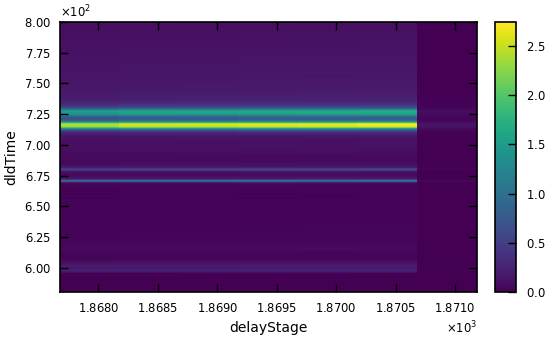

In [20]:

plt.figure()
res4D.mean(('dldPosX','dldPosY')).plot()

# with calibrations
### parameters are taken from the default values defined in the given settings file

In [70]:
prc = readData(35990,settings=settings)
prc.calibrateEnergy()
prc.calibrateMomentum()
prc.calibratePumpProbeTime(t0=1870)
prc.resetBins()

Using settings from Jonas_2020_express.ini
reading runs run35990: 0 new files of 27 total.
Loading 27 dataframes. Failed reading 0 files.
computing energy offsets...
[########################################] | 100% Completed |  6.4s


In [71]:
prc.resetBins()
prc.addBinning('energy',-43,-36,0.02)
# prc.addBinning('kx',-240,240,12)
# prc.addBinning('ky',-240,240,12)
prc.addBinning('pumpProbeTime',-1,3,.05)
res = prc.computeBinnedData()

  0%|          | 0/3 [00:00<?, ?it/s]

Failed creating metadata: 'forced to skip metadata creation'


<IPython.core.display.Javascript object>


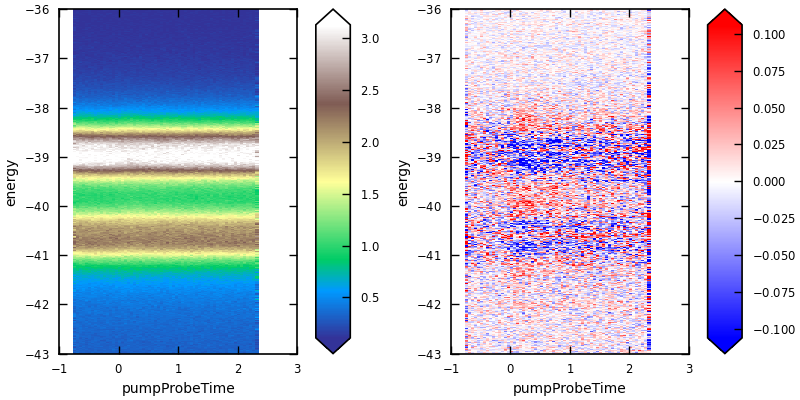

In [72]:
f,ax = plt.subplots(1,2,figsize=(8,4))
img = res/res.mean('energy')
img.plot(cmap='terrain',robust=True,ax=ax[0])
unp = img.sel(pumpProbeTime=slice(-10,-0.2)).mean('pumpProbeTime')
diff = (img-unp)
diff.plot(cmap='bwr',robust=True,ax=ax[1])
# pump = res.sel(pumpProbeTime=slice()).mean('pumpProbeTime')

In [74]:
prcold.dd.dldTime.

,dldPosX,dldPosY,dldTime,sampleBias,tofVoltage,extractorVoltage,delayStage,streakCamera,bam,dldMicrobunchId,dldDetectorId,dldSectorId,opticalDiode,gmdTunnel,gmdBda,monochromatorPhotonEnergy,macroBunchPulseId,timeStamp
npartitions=611,,,,,,,,,,,,,,,,,,
137760,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
200000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61100004,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61180019,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [75]:
prc.dd

,trainId,pulseId,electronId,bam,delayStage,cryoTemperature,dldTimeBinSize,extractorCurrent,extractorVoltage,sampleBias,sampleTemperature,tofVoltage,dldPosX,dldPosY,dldTime,gmdBda,gmdTunnel,monochromatorPhotonEnergy,opticalDiode
npartitions=27,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
